# Data Augmentation
In the previous lessons, you saw that having a high training accuracy does not automatically mean having a good predictive model. It can still perform poorly on new data because it has overfit to the training set. In this lab, you will see how to avoid that using data augmentation. This increases the amount of training data by modifying the existing training data's properties. For example, in image data, you can apply different preprocessing techniques such as rotate, flip, shear, or zoom on your existing images so you can simulate other data that the model should also learn from. This way, the model would see more variety in the images during training so it will infer better on new, previously unseen data.

Let's see how you can do this in the following sections.

## Baseline Performance 
You will start with a model that's very effective at learning Cats vs Dogs without data augmentation. It's similar to the previous models that you have used. Note that there are four convolutional layers with 32, 64, 128 and 128 convolutions respectively. The code is basically the same from the previous lab so we won't go over the details step by step since you've already seen it before.

You will train only for 20 epochs to save time but feel free to increase this if you want.

In [1]:
import os

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

You will place the model creation inside a function so you can easily initialize a new one when you use data augmentation later in this notebook.

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# Constant for epochs
EPOCHS = 20

# Create a new model
model = create_model()

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/20
100/100 - 39s - loss: 0.6854 - accuracy: 0.5400 - val_loss: 0.6644 - val_accuracy: 0.6420 - 39s/epoch - 392ms/step
Epoch 2/20
100/100 - 34s - loss: 0.6539 - accuracy: 0.6190 - val_loss: 0.6331 - val_accuracy: 0.6780 - 34s/epoch - 342ms/step
Epoch 3/20
100/100 - 33s - loss: 0.5982 - accuracy: 0.6845 - val_loss: 0.6047 - val_accuracy: 0.6950 - 33s/epoch - 334ms/step
Epoch 4/20
100/100 - 33s - loss: 0.5612 - accuracy: 0.7005 - val_loss: 0.5677 - val_accuracy: 0.7170 - 33s/epoch - 334ms/step
Epoch 5/20
100/100 - 35s - loss: 0.5207 - accuracy: 0.7350 - val_loss: 0.5787 - val_accuracy: 0.7030 - 35s/epoch - 351ms/step
Epoch 6/20
100/100 - 33s - loss: 0.4910 - accuracy: 0.7725 - val_loss: 0.5376 - val_accuracy: 0.7360 - 33s/epoch - 331ms/step
Epoch 7/20
100/100 - 34s - loss: 0.4607 - accuracy: 0.7805 - val_loss: 0.5572 - val_accuracy: 0.7340 - 34s/epoch - 340ms/step
Epoch 8/20
100/100 - 34s - loss: 0.4423 - accuracy: 0.7920 - val_loss: 0.5348 - val_accuracy: 0.7340 - 34s/epoch - 342

You will then visualize the loss and accuracy with respect to the training and validation set. You will again use a convenience function so it can be reused later. This function accepts a History object which contains the results of the fit() method you ran above.

In [15]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

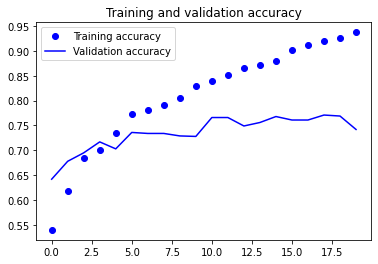

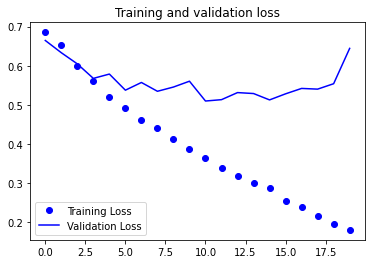

In [11]:
# Plot training results
plot_loss_acc(history)

## Data augmentation

One simple method to avoid overfitting is to augment the images a bit. If you think about it, most pictures of a cat are very similar -- the ears are at the top, then the eyes, then the mouth etc. Things like the distance between the eyes and ears will always be quite similar too.

What if you tweak with the images a bit -- rotate the image, squash it, etc. That's what image augementation is all about. And there's an API that makes it easy!

Take a look at the ImageDataGenerator which you have been using to rescale the image. There are other properties on it that you can use to augment the image.

#Updated to do image augmentation
train_datagen = ImageDataGenerator(

    rotation_range=40,
      
      width_shift_range=0.2,
      
      height_shift_range=0.2,
      
      shear_range=0.2,
      
      zoom_range=0.2,
      
      horizontal_flip=True,
      
      fill_mode='nearest')   
These are just a few of the options available. Let's quickly go over it:

- `rotation_range` is a value in degrees (0–180) within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
Run the next cells to see the impact on the results. The code is similar to the baseline but the definition of train_datagen has been updated to use the parameters described above.

In [13]:
# Create new model
model_for_aug = create_model()

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Train the new model
history_with_aug = model_for_aug.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 34s 338ms/step - loss: 0.6945 - accuracy: 0.5220 - val_loss: 0.6867 - val_accuracy: 0.5440
Epoch 2/20
100/100 [==============================] - 34s 339ms/step - loss: 0.6846 - accuracy: 0.5525 - val_loss: 0.6683 - val_accuracy: 0.6040
Epoch 3/20
100/100 [==============================] - 33s 328ms/step - loss: 0.6667 - accuracy: 0.5835 - val_loss: 0.6374 - val_accuracy: 0.6580
Epoch 4/20
100/100 [==============================] - 33s 327ms/step - loss: 0.6572 - accuracy: 0.6135 - val_loss: 0.7189 - val_accuracy: 0.5200
Epoch 5/20
100/100 [==============================] - 34s 339ms/step - loss: 0.6336 - accuracy: 0.6470 - val_loss: 0.6329 - val_accuracy: 0.6090
Epoch 6/20
100/100 [==============================] - 33s 327ms/step - loss: 0.6242 - accuracy: 0.6450 - val_loss: 0.5834 - val_accuracy: 0.6970
Epoch 7/20
100/100 [==========================

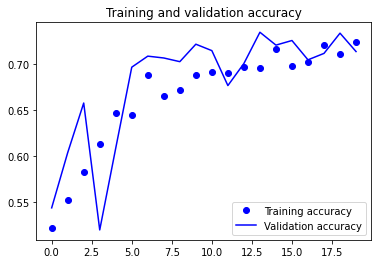

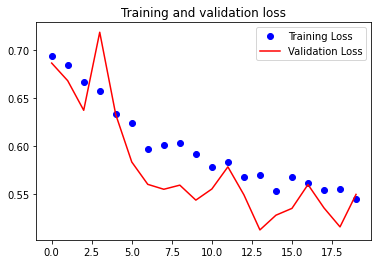

In [16]:
# Plot the results of training with data augmentation
plot_loss_acc(history_with_aug)

As you can see, the training accuracy has gone down compared to the baseline. This is expected because (as a result of data augmentation) there are more variety in the images so the model will need more runs to learn from them. The good thing is the validation accuracy is no longer stalling and is more in line with the training results. This means that the model is now performing better on unseen data.